In [28]:
import numpy as np
import pandas as pd
import math
import scipy as sp
import netCDF4
import gsw # this will be VERY useful https://github.com/TEOS-10/GSW-Python

# 1. Download synthetic argo file (= S-file)

In [29]:
# import requests
# import urllib 
# import ftplib
import wget
import os

def download_float(dac, wmo):
    """
    dac : data center, e.g. 'coriolis'
    wmo : world id of the float (unique), e.g. 6901866
    """
    
    # check if float folder exists
    if(os.path.isdir('./floats') == False):
        print("Directory 'floats' does not exist")
        print("It's being created in your current path")
        os.mkdir(os.path.join(os.getcwd(),'floats'))
    # check if file already exists in that folder
    if(os.path.isfile(os.getcwd()+'/floats/'+str(wmo)+'_Sprof.nc') == False):
        print("File does not exist")
        print("File is being downloaded")
        print("...")
        base_url = 'ftp://ftp.ifremer.fr/ifremer/argo/dac/'
        full_url = base_url+dac+'/'+str(wmo)+'/'
        link = full_url+str(wmo)+'_Sprof.nc'
        wget.download(link, out = os.getcwd()+'/floats/')
        print("Done !")
    else:
        print("File already exists, moving on.")

In [30]:
download_float('coriolis',6900798)
download_float('coriolis',6901866)

File already exists, moving on.
File already exists, moving on.


# 2. Extract data from NetCDF

In [31]:
# Read data

def read_data(ncfile):
    
    # see also the doc for SYNTHETIC BGC-ARGO files: https://archimer.ifremer.fr/doc/00445/55637/75359.pdf
    nc = netCDF4.Dataset(os.getcwd()+'/floats/'+ncfile, mode='r') # add a get url download the file in a folder then read it
    # get coordinates variables
    lat = nc.variables['LATITUDE'][:].data
    lon = nc.variables['LONGITUDE'][:].data
    time = nc.variables['JULD'][:].data
    depth = nc.variables['PRES'][:].data
    depth_qc = nc.variables['PRES_QC'][:].data
    
    #other parameters
    bbp = nc.variables['BBP700'][:].data
    bbp_qc = nc.variables['BBP700_QC'][:].data
    chla = nc.variables['CHLA'][:].data
    chla_qc = nc.variables['CHLA_QC'][:].data
    temp = nc.variables['TEMP'][:].data
    temp_qc = nc.variables['TEMP_QC'][:].data
    psal = nc.variables['PSAL'][:].data
    psal_qc = nc.variables['PSAL_QC'][:].data
    
    # close netcdf
    nc.close()
    
    # put data into a Dataframe
    data = pd.DataFrame({'depth':np.concatenate(depth), 'depth_qc':np.concatenate(depth_qc), 'temp':np.concatenate(temp),
              'temp_qc':np.concatenate(temp_qc), 'psal':np.concatenate(psal), 'psal_qc':np.concatenate(psal_qc),
              'chla':np.concatenate(chla), 'chla_qc':np.concatenate(chla_qc), 'bbp':np.concatenate(bbp), 
              'bbp_qc':np.concatenate(bbp_qc)})
    
    # number of profiles in the file
    n_prof = len(time)
    
    # repeat metadata to fit data length
    points_per_profile = data.shape[0]/n_prof
    time = np.repeat(time, points_per_profile)
    lat = np.repeat(lat, points_per_profile)
    lon = np.repeat(lon, points_per_profile)
    data['time'] = time
    data['lat'] = lat
    data['lon'] = lon

    # add profile IDs in a similar way, assuming the hypothesis of constant length per profile is correct (thanks to S profiles?)
    ids = np.array(range(1,n_prof+1))
    data['id'] = np.repeat(ids, points_per_profile)
    
    # some additional cleaning
    FillValue = 99999.0
    data = data.replace(FillValue, 'NaN')
    
    return(data)

In [48]:
data = read_data('6901866_Sprof.nc')
data = read_data('6900798_Sprof.nc')

In [49]:
data

,depth,depth_qc,temp,temp_qc,psal,psal_qc,chla,chla_qc,bbp,bbp_qc,time,lat,lon,id
0,4.2,b'1',8.363,b'1',35.256,b'1',NaN,b' ',NaN,b' ',22097.779155,69.088,2.434,1
1,6,b'1',8.365,b'1',35.256,b'1',3.0744,b'3',0.00310812,b'2',22097.779155,69.088,2.434,1
2,8,b'1',8.364,b'1',35.256,b'1',NaN,b' ',NaN,b' ',22097.779155,69.088,2.434,1
3,10,b'1',8.365,b'1',35.255,b'1',2.86654,b'3',0.00318367,b'2',22097.779155,69.088,2.434,1
4,12,b'1',8.363,b'1',35.254,b'1',NaN,b' ',NaN,b' ',22097.779155,69.088,2.434,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214457,1196.1,b'1',-0.446,b'1',34.908,b'1',NaN,b' ',NaN,b' ',23996.989942,77.675,-1.998,314
214458,1197.4,b'1',-0.447,b'1',34.908,b'1',NaN,b' ',NaN,b' ',23996.989942,77.675,-1.998,314
214459,NaN,b' ',NaN,b' ',NaN,b' ',NaN,b' ',NaN,b' ',23996.989942,77.675,-1.998,314
214460,NaN,b' ',NaN,b' ',NaN,b' ',NaN,b' ',NaN,b' ',23996.989942,77.675,-1.998,314


# 3. Some data cleaning
- convert QC bytes into integers
- remove depth where we don't have BBP data ==> this needs to be validated and check the order with the additional QCs to be applied

In [50]:
# convert QC bytes into integers
def bytes_to_int(x):
    try:
        x = int(x)
    except:
        x = 'NaN'
    return(x)

In [51]:
# apply that function where it is needed
data['temp_qc'] = data['temp_qc'].apply(bytes_to_int)
data['psal_qc'] = data['psal_qc'].apply(bytes_to_int)
data['depth_qc'] = data['depth_qc'].apply(bytes_to_int)
data['chla_qc'] = data['chla_qc'].apply(bytes_to_int)
data['bbp_qc'] = data['bbp_qc'].apply(bytes_to_int)

In [52]:
# remove depth where we don't have BBP data
# NOTE : is that correct? If not, we may have troubles with the median filter. OR we can let NaN be present in
# BBP data but then write a median filter that does not take them into account? Which is probably the case? 
# To check with Giorgio
data = data[data.bbp != 'NaN']
data

,depth,depth_qc,temp,temp_qc,psal,psal_qc,chla,chla_qc,bbp,bbp_qc,time,lat,lon,id
1,6,1,8.365,1,35.256,1,3.0744,3,0.00310812,2,22097.779155,69.088,2.434,1
3,10,1,8.365,1,35.255,1,2.86654,3,0.00318367,2,22097.779155,69.088,2.434,1
6,16,1,8.176,1,35.249,1,4.23725,3,0.00368133,2,22097.779155,69.088,2.434,1
8,20,1,7.59,1,35.237,1,5.99444,3,0.00288482,2,22097.779155,69.088,2.434,1
11,26,1,7.514,1,35.238,1,3.63502,4,0.00203976,2,22097.779155,69.088,2.434,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214342,974.86,1,-0.22686,8,34.915,8,0.0072,3,0.000278045,2,23996.989942,77.675,-1.998,314
214356,1000.09,1,-0.27136,8,34.913,8,0.0072,3,0.000266734,2,23996.989942,77.675,-1.998,314
214382,1050.12,1,-0.321021,8,34.912,8,0.0072,3,0.000266619,2,23996.989942,77.675,-1.998,314
214408,1100.52,1,-0.36778,8,34.91,8,0.0144,3,0.000266513,2,23996.989942,77.675,-1.998,314


# 4. Compute density

In [53]:
# compute density
# see https://teos-10.github.io/GSW-Python/
psal = gsw.SA_from_SP(np.array(data['psal']), np.array(data['depth']), np.array(data['lon']), np.array(data['lat']))
temp = gsw.CT_from_t(psal, np.array(data['temp']), np.array(data['depth']))
sigma = gsw.sigma0(psal, temp)
data['sigma'] = sigma

/home/flo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# 5. Additional QCs (to be done)

In [54]:
# to be done : apply some additionnal QC on BBP data
# QUESTION: before of after removing the NaN (if needed) => see below

# 6. Some plots

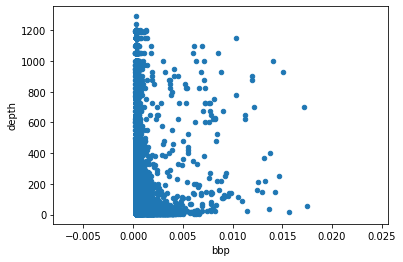

In [55]:
data.plot.scatter(x = 'bbp', y = 'depth')

In [56]:
# # plot some data
# from plotnine import ggplot, aes, geom_point, geom_line
# tmp = data[data.id == 1][:10]
# tmp.reset_index(inplace=True)#, drop=True)
# (ggplot(data = tmp) + aes(x = 'temp', y = 'depth') + geom_point()) #+ scale_y_reverse()

# ==> for an unknown reason, plotnine does not behave like it used to..

# 7. Remove dark offset  ==> remark maybe it's just ONE value per float and not per profile

In [57]:
def remove_dark_offset(group):
    min_bbp = np.nanmin(group['bbp'])
    group['bbp'] = group['bbp'] - min_bbp
    return(group)

In [58]:
data = data.groupby('id').apply(remove_dark_offset)

# 8. Apply median filter on BBP data

In [59]:
# median filter on BBP data ==> this needs to be done for EACH profile individually
from scipy import signal

# def medfilt (x, k):
#     """Apply a length-k median filter to a 1D array x.
#     Boundaries are extended by repeating endpoints.
#     """
#     assert k % 2 == 1, "Median filter length must be odd."
#     assert x.ndim == 1, "Input must be one-dimensional."
#     k2 = (k - 1) // 2
#     y = np.zeros ((len (x), k), dtype=x.dtype)
#     y[:,k2] = x
#     for i in range (k2):
#         j = k2 - i
#         y[j:,i] = x[:-j]
#         y[:j,i] = x[0]
#         y[:-j,-(i+1)] = x[j:]
#         y[-j:,-(i+1)] = x[-1]
#     return np.median (y, axis=1)

# def medianfilter(group):
#     smoothed = signal.medfilt(group['bbp'],5) # kernel size = 5
#     return(pd.Series(smoothed)) # apply on dataframe MUST return a dataframe, a series or a scaler, not a numpy array

# # not a pretty code but it works ..
# # grouped['bbp'].apply(lambda x: signal.medfilt(x, kernel_size = 5))
# tmp = data.groupby('id').apply(medianfilter)
# tmp = tmp.reset_index()
# data['bbp'] = np.array(tmp[0])

def medianfilter(group):
    smoothed = signal.medfilt(group['bbp'],5) # kernel size = 5
    group['bbp'] = smoothed
    return(group)

tmp = data.groupby('id').apply(medianfilter)

# 9. Computation of the Mixed Layer Depth (MLD)
- sigma criteria : 0.03 kg/m³ instead of 0.1
- depth ref = 10 m
- See Kara et al., 2003:  https://doi.org/10.1029/2000JC000736)

In [60]:
sigma_criteria = 0.03
depth_ref = 10
from scipy.interpolate import interp1d

def compute_MLD(group): # this will probably need to be adapted after QC application (for NaN for instance, or if sigma data between the surface and 10m are bad)
    # approx sigma et 10m
    f = interp1d(group['depth'], group['sigma']) # linear interp
    # we define sigma_surface as sigma at 10m
    sigma_surface = float(f(depth_ref))
    MLD = np.min(group[group['sigma'] >= sigma_surface + sigma_criteria]['depth'])
    group['MLD'] = np.repeat(MLD, group.shape[0])
    return(group)

data = data.groupby('id').apply(compute_MLD)

ValueError: A value in x_new is below the interpolation range.

# 10. Convert BBP to POC

In [45]:
# some criteria (NB: empirical factors)
withinMLD = 37.530
belowMLD = 31.620

def BBP_to_POC(group):
    MLD = np.max(group['MLD'])
    # POC from BBP
    # within MLD
    tmp1 = group[group.depth <= MLD]['bbp']*withinMLD
    # below MLD
    tmp2 = group[group.depth > MLD]['bbp']*belowMLD
    # concat data
    group['poc'] = pd.concat([tmp1, tmp2])
    return(group)

In [46]:
data = data.groupby('id').apply(BBP_to_POC)

In [47]:
data

,depth,depth_qc,temp,temp_qc,psal,psal_qc,chla,chla_qc,bbp,bbp_qc,time,lat,lon,id,sigma,MLD,poc
6,0.6,1,18.2667,3,17.9628,3,0.74533,3,0.00592033,2,23887.953472,43.160053,28.970448,1,12.217158,10.70,0.22219
16,1.6,1,18.244,1,17.9,3,0.75263,3,0.00622672,2,23887.953472,43.160053,28.970448,1,12.174396,10.70,0.233689
26,2.6,1,18.19,1,17.851,3,0.74314,3,0.0063377,2,23887.953472,43.160053,28.970448,1,12.149024,10.70,0.237854
36,3.6,1,18.074,1,17.802,3,0.82782,3,0.00622794,2,23887.953472,43.160053,28.970448,1,12.137158,10.70,0.233734
46,4.6,1,17.901,1,17.962,3,0.84826,3,0.00637545,2,23887.953472,43.160053,28.970448,1,12.296558,10.70,0.239271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593532,811.76,1,8.92715,8,22.2226,8,0.314176,3,0.00259408,2,25389.418750,41.529832,31.588572,301,17.152988,10.64,0.0820247
593542,853.01,1,8.93309,8,22.2362,8,0.3212,3,3.43856e-05,2,25389.418750,41.529832,31.588572,301,17.163378,10.64,0.00108727
593552,898.37,1,8.94118,8,22.2492,8,0.321432,3,5.57425e-05,2,25389.418750,41.529832,31.588572,301,17.173074,10.64,0.00176258
593563,947.79,1,8.9491,8,22.2611,8,0.328138,3,9.16286e-05,2,25389.418750,41.529832,31.588572,301,17.182004,10.64,0.0028973


# TO DO
- compute the depth of the bottom of the euphotic zone (3 différents ways possible but two to really compare)
- then go to the integration -> use scipy for this
- check the right order of every section
- QC the data (with the QC of 2012 first (see Dall'Olmo) but then check w/ Raphaelle Sauzede
- convert julian day and human time

In [ ]:
tmp